In [3]:
from __future__ import division, print_function, absolute_import 

import matplotlib.pyplot as plt
%matplotlib inline
# import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import numpy as np
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.table as table
import astropy.units as u
from astropy.coordinates import SkyCoord

# A few definitions

In [4]:
single_figure = (8,8)

In [5]:
import matplotlib as mpl
mpl.rcParams['lines.markeredgewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.fontsize'] = 16
# mpl.rcParams[''] = 

In [6]:
ecliptic = SkyCoord(np.linspace(0,360,1000),np.zeros(1000),unit=u.deg,frame="barycentrictrueecliptic")

# Plot the distribution of open clusters on the sky

## First read in the cluster data

Kharchenko et al. (2013) looked for clusters primarily in the Galactic Plane 

In [7]:
# Read in the cluster catalog
khar_full = at.read("kharchenko2013_clusters.csv",delimiter=",",
                data_start=1,header_start=0)
# NGC_2632 (M44) and Hyades aren't in there (too nearby to appear as an overdensity)
# Print the catalog columns
print(khar_full.dtype)

[('MWSC', '<i8'), ('Name', '<U17'), ('Type', '<U7'), ('n_Type', '<U1'), ('RAJ2000', '<f8'), ('DEJ2000', '<f8'), ('GLON', '<f8'), ('GLAT', '<f8'), ('r0', '<f8'), ('r1', '<f8'), ('r2', '<f8'), ('pmRA', '<f8'), ('pmDE', '<f8'), ('RV', '<f8'), ('e_RV', '<f8'), ('o_RV', '<i8'), ('N1sr0', '<i8'), ('N1sr1', '<i8'), ('N1sr2', '<i8'), ('d', '<i8'), ('E(B-V)', '<f8'), ('MOD', '<f8'), ('E(J-Ks)', '<f8'), ('E(J-H)', '<f8'), ('dH', '<f8'), ('logt', '<f8'), ('e_logt', '<f8'), ('Nt', '<i8'), ('SType', '<U3'), ('[Fe/H]', '<U6'), ('e_[Fe/H]', '<f8'), ('o_[Fe/H]', '<i8'), ('Simbad', '<U6'), ('col33', '<U6')]


In [8]:
# I'm only interested in Open Clusters, which have a "Type" set in the catalog
ocs = khar_full["Type"].mask.nonzero()[0]
# print(ocs)
# Select a smaller catalog, made only of OCs
khar = khar_full[ocs]

In [9]:
# Compute the height of each cluster above the Galactic Plane
# GLAT is the cluster's galactic latitude, and "d" is its distance
# Then we just use simple Trig
khar_z = np.sin(khar["GLAT"] * np.pi / 180) * khar["d"]
# print(khar_z)


# Define a SkyCoord object using the RA (longitude on the sky)
# and Decliation (latitude on the sky) of each cluster
khar_pos = SkyCoord(khar["RAJ2000"],khar["DEJ2000"],
                     unit=u.deg,frame="icrs")

Schmeja et al. (2014) extended the Kharchenko catalog, but focused on far away clusters that were missed in their initial search

In [10]:
# Read in the catalog
schm = at.read("schmeja2014_clusters.csv",delimiter=",",
               data_start=1,header_start=0)
print(schm.dtype)

# Also compute the height above the Galactic plane
# and generate a SkyCoord object for the Schmeja clusters
schm_z = np.sin(schm["GLAT"] * np.pi / 180) * schm["d"]
schm_pos = SkyCoord(schm["RAJ2000"],schm["DEJ2000"],unit=u.deg,frame="icrs")

[('MWSC', '<i8'), ('N', '<i8'), ('Name', '<U9'), ('Type', '<U1'), ('n_Type', '<U1'), ('RAJ2000', '<f8'), ('DEJ2000', '<f8'), ('GLON', '<f8'), ('GLAT', '<f8'), ('r0', '<f8'), ('r1', '<f8'), ('r2', '<f8'), ('pmRA', '<f8'), ('pmDE', '<f8'), ('N1sr0', '<i8'), ('N1sr1', '<i8'), ('N1sr2', '<i8'), ('d', '<i8'), ('E(B-V)', '<f8'), ('MOD', '<f8'), ('E(J-Ks)', '<f8'), ('E(J-H)', '<f8'), ('deltaH', '<f8'), ('logt', '<f8'), ('e_logt', '<f8'), ('Nt', '<i8')]


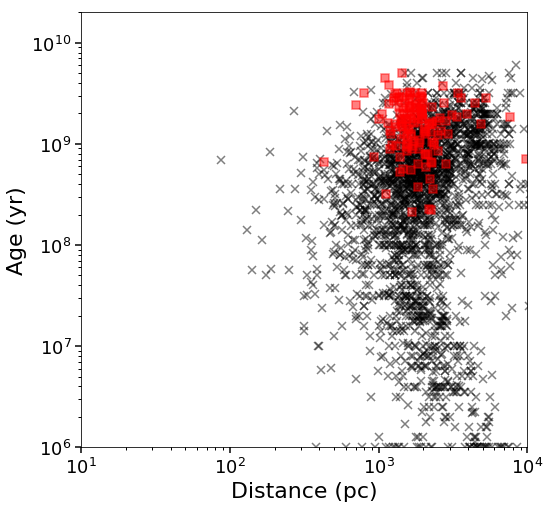

In [11]:
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

ax.plot(khar["d"],10**khar["logt"],'kx',alpha=0.5)
ax.plot(schm["d"],10**schm["logt"],'rs',alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(10,1e4)
ax.set_ylim(1e6,2e10)

ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Age (yr)")

plt.savefig("all_clusters_age_dist.png",bbox_inches="tight",dpi=300)

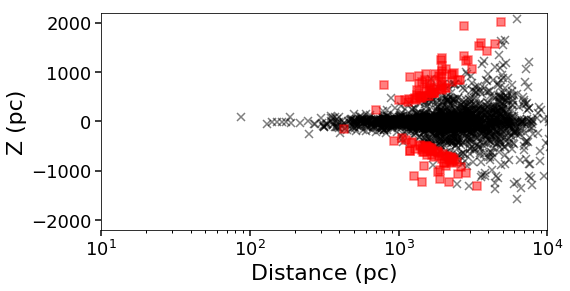

In [12]:
plt.figure(figsize=(8,4))
ax2 = plt.subplot(111)

ax2.plot(khar["d"],khar_z,'kx',alpha=0.5)
ax2.plot(schm["d"],schm_z,'rs',alpha=0.5)

ax2.set_xscale("log")
ax2.set_xlim(10,1e4)
ax2.set_ylim(-2.2e3,2.2e3)

ax2.set_xlabel("Distance (pc)")
ax2.set_ylabel("Z (pc)")

plt.savefig("all_clusters_age_Z.png",bbox_inches="tight",dpi=300)

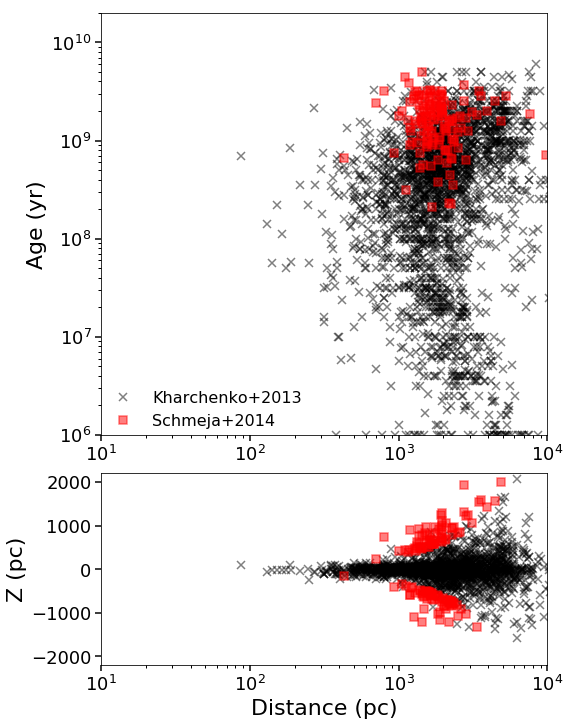

In [13]:
plt.figure(figsize=(8,12))
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=2)

ax1.plot(khar["d"],10**khar["logt"],'kx',alpha=0.5,label="Kharchenko+2013")
ax1.plot(schm["d"],10**schm["logt"],'rs',
         alpha=0.5,label="Schmeja+2014")

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlim(10,1e4)
ax1.set_ylim(1e6,2e10)

# ax1.set_xlabel("Distance (pc)")
ax1.set_ylabel("Age (yr)")

ax1.legend(loc=3,borderaxespad=0)

ax2 = plt.subplot2grid((3,1),(2,0),rowspan=1)

ax2.plot(khar["d"],khar_z,'kx',alpha=0.5)
ax2.plot(schm["d"],schm_z,'rs',alpha=0.5)


ax2.set_xscale("log")
ax2.set_xlim(10,1e4)
ax2.set_ylim(-2.2e3,2.2e3)

ax2.set_xlabel("Distance (pc)")
ax2.set_ylabel("Z (pc)")

plt.savefig("all_clusters.png",bbox_inches="tight")

Text(0,0.5,'b (deg)')

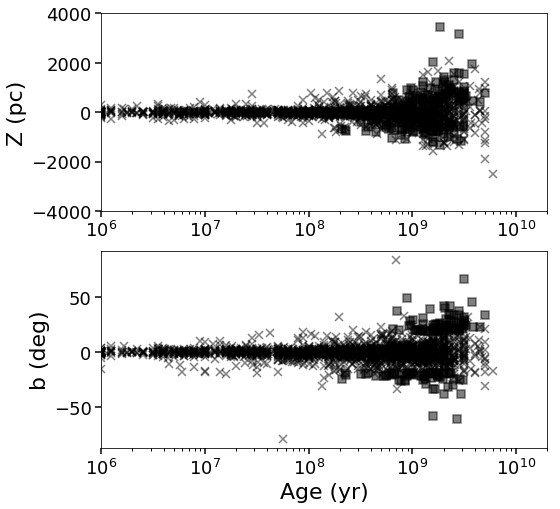

In [14]:
plt.figure(figsize=single_figure)
ax1 = plt.subplot(211)

ax1.plot(10**khar["logt"],khar_z,'kx',alpha=0.5)
ax1.plot(10**schm["logt"],schm_z,'ks',alpha=0.5,label="Schmeja+2014")

ax1.set_xscale("log")
ax1.set_xlim(1e6,2e10)
ax1.set_ylim(-4e3,4e3)

# ax1.set_xlabel("Distance (pc)")
ax1.set_ylabel("Z (pc)")


ax2 = plt.subplot(212)

ax2.plot(10**khar["logt"],khar["GLAT"],'kx',alpha=0.5)
ax2.plot(10**schm["logt"],schm["GLAT"],'ks',alpha=0.5,label="Schmeja+2014")

ax2.set_xscale("log")
# ax.set_yscale("log")

ax2.set_xlim(1e6,2e10)

ax2.set_xlabel("Age (yr)")
ax2.set_ylabel("b (deg)")



Text(0,0.5,'b (deg)')

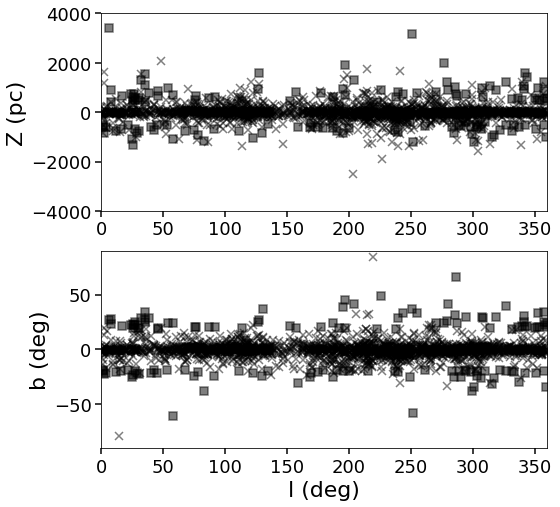

In [29]:
plt.figure(figsize=single_figure)
ax1 = plt.subplot(211)

ax1.plot(khar["GLON"],khar_z,'kx',alpha=0.5)
ax1.plot(schm["GLON"],schm_z,'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

# ax1.set_xscale("log")
ax1.set_xlim(0,360)
ax1.set_ylim(-4e3,4e3)

# ax1.set_xlabel("Distance (pc)")
ax1.set_ylabel("Z (pc)")


ax2 = plt.subplot(212,sharex=ax1)

ax2.plot(khar["GLON"],khar["GLAT"],'kx',alpha=0.5)
ax2.plot(schm["GLON"],schm["GLAT"],'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

# ax2.set_xscale("log")
# ax.set_yscale("log")

ax2.set_ylim(-90,90)
ax2.set_xlim(0,360)

ax2.set_xlabel("l (deg)")
ax2.set_ylabel("b (deg)")



# What if we want to plot the clusters in a sky projection?

For more information on using geometric projections in Matplotlib, see 
https://matplotlib.org/gallery/subplots_axes_and_figures/geo_demo.html

First, we'll plot in the "aitoff" projection, which is commonly used. 

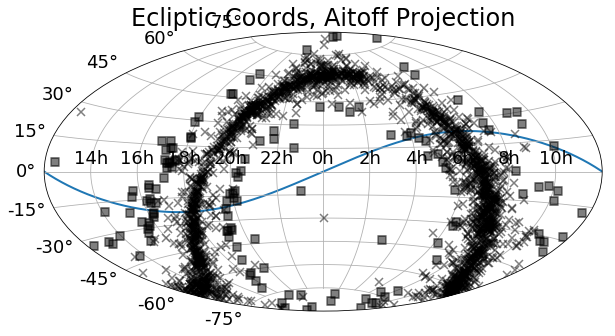

In [28]:
plt.figure(figsize=(10,8))
# Define the subplot axis, and set the appropriate projection keyword
ax = plt.subplot(111, projection="aitoff")

# Now plot the RA and Dec of each cluster
# To force 0h RA to be centered on the plot, we have to force 
# the RA to "wrap" at 12h (180 degrees), so that RA runs from -180 to 180
ax.plot(khar_pos.ra.wrap_at(180 * u.deg).radian,khar_pos.dec.radian,
        'kx',alpha=0.5,label="Kharchenko+2013")
ax.plot(schm_pos.ra.wrap_at(180 * u.deg).radian,schm_pos.dec.radian,
        'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

# Now we re-label the axes to be the familiar hours of RA
# If we were working with Earth-based data, then you could skip this step
# and leave longitude as degrees from -180 to 180
ax.set_xticklabels(['14h','16h','18h','20h','22h',
                    '0h','2h','4h','6h','8h','10h'])

# Turn on the axes background grid
ax.grid(True)

# Plotting the ecliptic plane (the plane of the Solar System,
# where the Sun and planets appear to travel across the sky)
# Takes some extra work. First wrap the ecliptic RA at 180, as above
ecliptic_ra = ecliptic.icrs.ra.wrap_at(180 * u.deg).radian
ecliptic_dec = ecliptic.icrs.dec.radian
# We have to re-sort those arrays to match the min and max of our current plot
new_ecl = np.argsort(ecliptic_ra)
ecliptic_ra = ecliptic_ra[new_ecl]
ecliptic_dec = ecliptic_dec[new_ecl]
# Which lets the line go smoothly from left to right!
ax.plot(ecliptic_ra,ecliptic_dec,'-',lw=2,zorder=-1)
_ = plt.title("Ecliptic Coords, Aitoff Projection")

So the above plot is in Equatorial coordinates - as though you projected the Earth's lat/long outward onto the sky in RA/Dec. The plane of the solar system is shown in the line, and the Galactic plane is shown by the location of all those clusters

We can plot this in some other fun projections as well

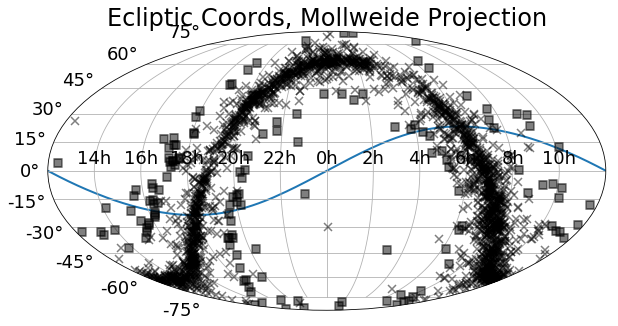

In [24]:
plt.figure(figsize=(10,8))
# Define the subplot axis, and set the appropriate projection keyword
ax = plt.subplot(111, projection="mollweide")

# Now plot the RA and Dec of each cluster
# To force 0h RA to be centered on the plot, we have to force 
# the RA to "wrap" at 12h (180 degrees), so that RA runs from -180 to 180
ax.plot(khar_pos.ra.wrap_at(180 * u.deg).radian,khar_pos.dec.radian,
        'kx',alpha=0.5,label="Kharchenko+2013")
ax.plot(schm_pos.ra.wrap_at(180 * u.deg).radian,schm_pos.dec.radian,
        'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

# Now we re-label the axes to be the familiar hours of RA
# If we were working with Earth-based data, then you could skip this step
# and leave longitude as degrees from -180 to 180
ax.set_xticklabels(['14h','16h','18h','20h','22h',
                    '0h','2h','4h','6h','8h','10h'])

# Turn on the axes background grid
ax.grid(True)

# Plotting the ecliptic plane (the plane of the Solar System,
# where the Sun and planets appear to travel across the sky)
# Takes some extra work. First wrap the ecliptic RA at 180, as above
ecliptic_ra = ecliptic.icrs.ra.wrap_at(180 * u.deg).radian
ecliptic_dec = ecliptic.icrs.dec.radian
# We have to re-sort those arrays to match the min and max of our current plot
new_ecl = np.argsort(ecliptic_ra)
ecliptic_ra = ecliptic_ra[new_ecl]
ecliptic_dec = ecliptic_dec[new_ecl]
# Which lets the line go smoothly from left to right!
ax.plot(ecliptic_ra,ecliptic_dec,'-',lw=2,zorder=-1)

_ = plt.title("Ecliptic Coords, Mollweide Projection")

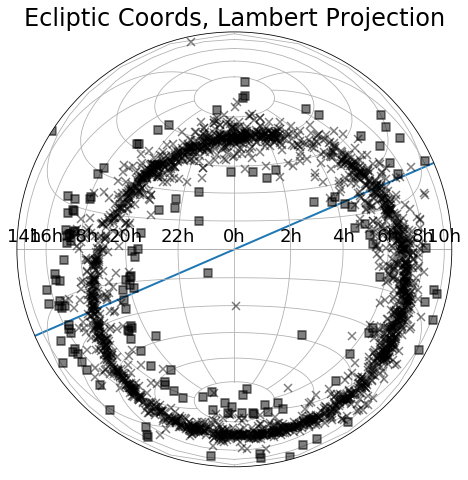

In [23]:
plt.figure(figsize=(10,8))
# Define the subplot axis, and set the appropriate projection keyword
ax = plt.subplot(111, projection="lambert")

# Now plot the RA and Dec of each cluster
# To force 0h RA to be centered on the plot, we have to force 
# the RA to "wrap" at 12h (180 degrees), so that RA runs from -180 to 180
ax.plot(khar_pos.ra.wrap_at(180 * u.deg).radian,khar_pos.dec.radian,
        'kx',alpha=0.5,label="Kharchenko+2013")
ax.plot(schm_pos.ra.wrap_at(180 * u.deg).radian,schm_pos.dec.radian,
        'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

# Now we re-label the axes to be the familiar hours of RA
# If we were working with Earth-based data, then you could skip this step
# and leave longitude as degrees from -180 to 180
ax.set_xticklabels(['14h','16h','18h','20h','22h',
                    '0h','2h','4h','6h','8h','10h'])

# Turn on the axes background grid
ax.grid(True)

# Plotting the ecliptic plane (the plane of the Solar System,
# where the Sun and planets appear to travel across the sky)
# Takes some extra work. First wrap the ecliptic RA at 180, as above
ecliptic_ra = ecliptic.icrs.ra.wrap_at(180 * u.deg).radian
ecliptic_dec = ecliptic.icrs.dec.radian
# We have to re-sort those arrays to match the min and max of our current plot
new_ecl = np.argsort(ecliptic_ra)
ecliptic_ra = ecliptic_ra[new_ecl]
ecliptic_dec = ecliptic_dec[new_ecl]
# Which lets the line go smoothly from left to right!
ax.plot(ecliptic_ra,ecliptic_dec,'-',lw=2,zorder=-1)

_ = plt.title("Ecliptic Coords, Lambert Projection")

### Transform to Galactic Coordinates

Now let's go back to the aitoff projection, but plotting in Galactic coordinates, instead of Ecliptic coordinages

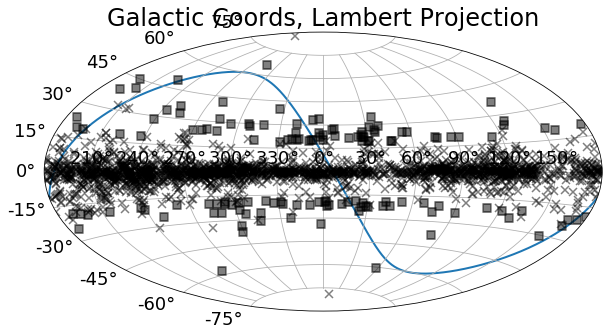

In [33]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection="aitoff")

# Astropy SkyCoord positions automatically include Galactic coordinates
# accessible using .galactic.l (for Galactic longitude)
# and .galactic.b (for Galactic latitude)
# And again we have to wrap the longitude at 180 degrees
# in order to center 0 on our plot
ax.plot(khar_pos.galactic.l.wrap_at(180 * u.deg).radian,
         khar_pos.galactic.b.radian,
         'kx',alpha=0.5,label="Kharchenko+2013")
ax.plot(schm_pos.galactic.l.wrap_at(180 * u.deg).radian,schm_pos.galactic.b.radian,
         'ks',mfc="none",alpha=0.5,label="Schmeja+2014")

ax.set_xticklabels([r"210$\degree$",r"240$\degree$",r"270$\degree$",
                   r"300$\degree$",r"330$\degree$",r"0$\degree$",
                   r"30$\degree$",r"60$\degree$",r"90$\degree$",
                   r"120$\degree$",r"150$\degree$",])
# ax.set_yticklabels([])
ax.grid(True)

# We have to rearrange the Ecliptic coordinates here too
ecliptic_l = ecliptic.galactic.l.wrap_at(180 * u.deg).radian
ecliptic_b = ecliptic.galactic.b.radian
new_ecl = np.argsort(ecliptic_l)
ecliptic_l = ecliptic_l[new_ecl]
ecliptic_b = ecliptic_b[new_ecl]

ax.plot(ecliptic_l,ecliptic_b,'-',lw=2,zorder=-1)

_ = plt.title("Galactic Coords, Aitoff Projection")